## Class 10 Agenda:
  * **Hierarchical/Agglomerative Clustering Description/Method**
  * **Linkage matrices and linkage methods**
  * **Visualizing hierarchical clustering using dendrograms**
  * **Generating flat clusters from hierarchical clustering**
  * **Different distance metrics and when to use them**

#### Outcomes
By the end of this lesson you will be able to:
  * use **hierarchical clustering** to visualize and create clusters from your dataset
  * explain how different linkage methods work in computing the hierarchical clustering dendrogram
  * understand the difference between **euclidean**, **squared euclidean**, **cosine**, **correlation**, **Manhattan**, **Chebyshev**, and **Jaccard** distance metrics, and when to use each.

### Advanced Unsupervised learning

The first time we learned about unsupervised learning approaches, we looked at 2 different approaches for clustering data - **K-Means Clustering** and **DBSCAN**. 

Because the clustering approach we will be exploring today can take any arbitrary distance metric, it is similar to DBSCAN, but because you can also specify how many clusters you would like output, it has some similarities to K-Means. This general approach is known as [**hierarchical/agglomerative clustering**](https://en.wikipedia.org/wiki/Hierarchical_clustering). Because hierarchical clustering takes any arbitrary distance metric to compute distances between samples, we will compare and contrast several common distance metrics for clustering, and learn about when it is/isn't appropriate to use each of them.

Let's start by importing what we will use today:

In [25]:
#data handling and clustering
import pandas as pd
import numpy as np
np.set_printoptions(precision=4,suppress=True)
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, fcluster, cophenet, set_link_color_palette
from scipy.spatial.distance import squareform
from fastcluster import linkage, pdist

# visualization
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

We are going to use the [Boston Housing Dataset](http://archive.ics.uci.edu/ml/datasets/Housing) to see if we can cluster towns near Boston meaningfully using hierarchical/agglomerative clustering. 

Each row is a town, and each column is a specific statistic measured in that town:

  1. **crime:** per capita crime rate by town
  2. **zone:** proportion of residential land zoned for lots over 25,000 sq.ft.
  3. **industry:** proportion of non-retail business acres per town
  4. **charles:** Charles River dummy variable (1 if tract bounds river; 0 otherwise)
  5. **no:** nitric oxides concentration (parts per 10 million)
  6. **rooms:** average number of rooms per dwelling
  7. **age:** proportion of owner-occupied units built prior to 1940
  8. **distance:** weighted distances to five Boston employment centres
  9. **radial:** index of accessibility to radial highways
  10. **tax:** full-value property-tax rate per 10K dollars
  11. **pupil:** pupil-teacher ratio by town
  12. **aam:** $1000(aam - 0.63)^2$ where aam is the proportion of african americans by town
  13. **lower:** percentage lower income status of the population
  14. **med_price:** Median value of owner-occupied homes in $1000's 
  
Let's begin by loading the data in:

In [26]:
#load the housing dataset in
housing_columns = ["crime","zone","industry","charles","no","rooms","age",
                   "distance","radial","tax","pupil","aam","lower","med_price"]
housing_data = pd.read_csv("../data/boston_housing.csv",names=housing_columns)
housing_columns = housing_columns[:3]+housing_columns[4:]+[housing_columns[3]]
housing_data = housing_data[housing_columns]
housing_data.head()

crime  zone  industry     no  rooms   age  distance  radial    tax  \
0  0.00632  18.0      2.31  0.538  6.575  65.2    4.0900       1  296.0   
1  0.02731   0.0      7.07  0.469  6.421  78.9    4.9671       2  242.0   
2  0.02729   0.0      7.07  0.469  7.185  61.1    4.9671       2  242.0   
3  0.03237   0.0      2.18  0.458  6.998  45.8    6.0622       3  222.0   
4  0.06905   0.0      2.18  0.458  7.147  54.2    6.0622       3  222.0   

   pupil     aam  lower  med_price  charles  
0   15.3  396.90   4.98       24.0        0  
1   17.8  396.90   9.14       21.6        0  
2   17.8  392.83   4.03       34.7        0  
3   18.7  394.63   2.94       33.4        0  
4   18.7  396.90   5.33       36.2        0

And normalizing it per-column:

In [27]:
sc = StandardScaler()
housing_data_scaled  = housing_data.copy()
housing_data_scaled[housing_columns[:-1]]  = sc.fit_transform(housing_data[housing_columns[:-1]])

And taking a look at the correlation matrix across all the samples, to see if there seems to be any interesting pairwise relationships among the samples (does it look like there might be some inherent structure):

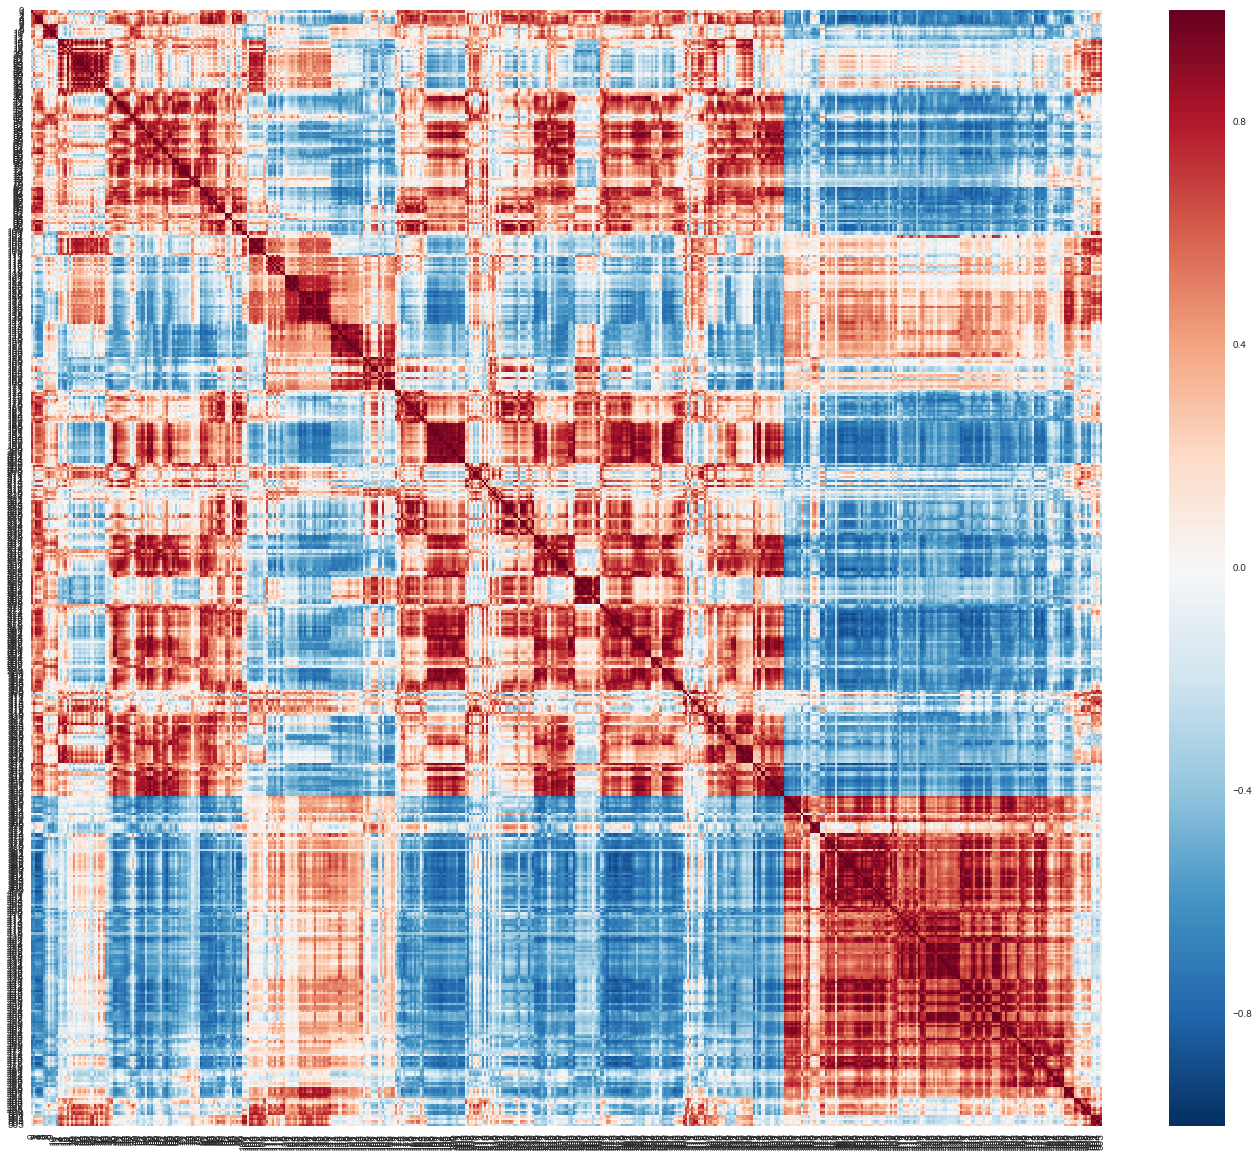

In [4]:
sns.plt.figure(figsize=(24,20))
sns.heatmap(housing_data_scaled.transpose().corr().values)

Looks like there's definitely some interesting structure in here, let's see if we can reveal it.

### Linkage matrices and linkage methods

A hierarchical clustering is in effect a clustering tree built across all the points in your dataset, so that at the very bottom of the tree, every point (row/sample) is in its own cluster, and at the very top of the tree, every point is in one megacluster.

In order to compute a hierarchical clustering on some dataset, you must specify 2 parameters:

  1. **A distance metric:** How you compute how far any two points are, given their positions in the space of your data. 
  2. **A linkage method:**  How you merge two clusters together, given that "cluster distance" can be specified in a variety of ways (is the distance between 2 clusters: The distance of each from the other's center? From each one's furthest points? Closest points?)

The general algorithm for hierarchical clustering is as follows:
  1. Begin with every point in its own cluster.
  2. Compute all pairwise distances (given an arbitrary distance metric) across all points in the dataset to generate a [**distance matrix**](https://en.wikipedia.org/wiki/Distance_matrix).
  3. Merge the two points that are closest to each other into a cluster.
  4. Going forward, only the closest clusters (as opposed to individual points) to each other are merged at successive levels, as defined by the linkage method you choose.

When you apply a linkage method to a distance matrix, you generate what is called a **linkage matrix**. This matrix defines which points/clusters are combined at each level of agglomeration (merging).

We are going to create our first linkage matrix using the function `linkage` from the [fastcluster package](http://danifold.net/fastcluster.html) which contains much faster implementations of the clustering algorithms found in `scipy.cluster.hierarchy`.

We can supply the distance metric we want to use to `linkage` and it will compute our distance matrix and then apply the chosen linkage method. `linkage` also takes precomputed distance matrices, so if you have that, you can pass it in directly.

Here we will use the `single` cluster merging method:

In [39]:
Z_single = linkage(housing_data_scaled, metric='euclidean', method='average')

There are several different kinds of cluster merging (called **linkage**) methods:

  1. **Single Linkage:** The distance between two clusters is the distance between the closest points in those clusters.
  2. **Average Linkage:** The distance between two clusters is the average of the distances between all the points in those clusters.
  3. **Complete Linkage:** The distance between two clusters is the distance between the furthest points in those clusters.
  4. **Ward Linkage:** The distance between two clusters is the sum of the squared distances across all points in those clusters. **Can only be used with Euclidean distance (and thus becomes a squared euclidean distace).**

Lets inspect the first 25 combined clusters in the linkage matrix:

In [40]:
print housing_data_scaled.shape
Z_single[:25]

(506, 14)


array([[ 320.    ,  321.    ,    0.1345,    2.    ],
       [ 128.    ,  137.    ,    0.1572,    2.    ],
       [ 333.    ,  334.    ,    0.2223,    2.    ],
       [ 382.    ,  383.    ,    0.2243,    2.    ],
       [ 130.    ,  131.    ,    0.2385,    2.    ],
       [ 121.    ,  125.    ,    0.2453,    2.    ],
       [ 103.    ,  104.    ,    0.2492,    2.    ],
       [ 122.    ,  124.    ,    0.2502,    2.    ],
       [ 441.    ,  443.    ,    0.2612,    2.    ],
       [ 336.    ,  339.    ,    0.2665,    2.    ],
       [  42.    ,   43.    ,    0.2736,    2.    ],
       [  13.    ,   15.    ,    0.2761,    2.    ],
       [  70.    ,   73.    ,    0.2939,    2.    ],
       [  90.    ,   91.    ,    0.2984,    2.    ],
       [ 230.    ,  235.    ,    0.303 ,    2.    ],
       [ 127.    ,  129.    ,    0.3059,    2.    ],
       [ 112.    ,  113.    ,    0.3121,    2.    ],
       [ 144.    ,  147.    ,    0.3304,    2.    ],
       [ 203.    ,  204.    ,    0.336 ,    2.

This matrix tells us the indices of the points to merge (first 2 columns), their distance according to the linkage criterion (3rd column), and the number of points being merged (4th column).

Notice that the one of the first two indexes in the second to last row is > 506 (the number of points in our dataset). This means that for that merge, we are merging a pre-merged cluster with a datapoint, where the index of the premerged-cluster is that cluster created at the n-n_points merge (so, for 507, it would be the first merge, 508 is the 2nd merge, etc.).

Let's plot all the succesive distances between clusters in the linkage matrix:

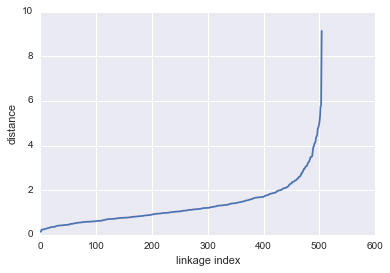

In [41]:
sns.plt.plot(np.arange(Z_single.shape[0]),Z_single[:,2])
sns.plt.xlabel("linkage index")
sns.plt.ylabel("distance")

This illustrates that every succesive merge is of clusters further apart than the current merged clusters.

We can also compute the full pairwise distance matrix (what every hierarchical clustering is made from), using the function `pdist`:

In [42]:
distances_euclidean = pdist(housing_data_scaled, metric='euclidean')
distances_euclidean

array([ 1.9376,  2.2832,  2.5767, ...,  0.3742,  1.9437,  1.5898])

However, because this function doesn't generate a square matrix, we can convert the resulting array back into a squareform matrix, just to see what those distances look like:

In [43]:
distances_square = squareform(distances_euclidean)
distances_square

array([[ 0.    ,  1.9376,  2.2832, ...,  3.411 ,  3.3469,  3.6056],
       [ 1.9376,  0.    ,  2.033 , ...,  2.5359,  2.3685,  2.5252],
       [ 2.2832,  2.033 ,  0.    , ...,  2.8233,  2.897 ,  3.8165],
       ..., 
       [ 3.411 ,  2.5359,  2.8233, ...,  0.    ,  0.3742,  1.9437],
       [ 3.3469,  2.3685,  2.897 , ...,  0.3742,  0.    ,  1.5898],
       [ 3.6056,  2.5252,  3.8165, ...,  1.9437,  1.5898,  0.    ]])

To evaluate how well a given hierarchical clustering reflects this initial distance matrix, we can compute the [Cophenetic correlation coefficient](https://en.wikipedia.org/wiki/Cophenetic_correlation), which is a measure of how faithfully a dendrogram preserves the pairwise distances between the original unmodeled data points.

Let's calculate this metric to see how good our hierarchical clustering is:

In [44]:
avg_cophenet,coph_dists = cophenet(Z_single,distances_euclidean)
print "Cophenetic correlation, euclidean distance with average linkage:",avg_cophenet

Cophenetic correlation, euclidean distance with average linkage: 0.768597219421


#### Exercise Time

* Generate the average, single, complete, and ward linkage matrices for this data and compute their respective cophenetic coefficients. Which cophenetic coefficient is highest? Does this make it the best clustering?

In [9]:
pass

### Visualizing Dendrograms

We can visualize a hierarchical clustering by looking at its **dendrogram**. Let's draw the dendrogram for our hierarchical clustering:

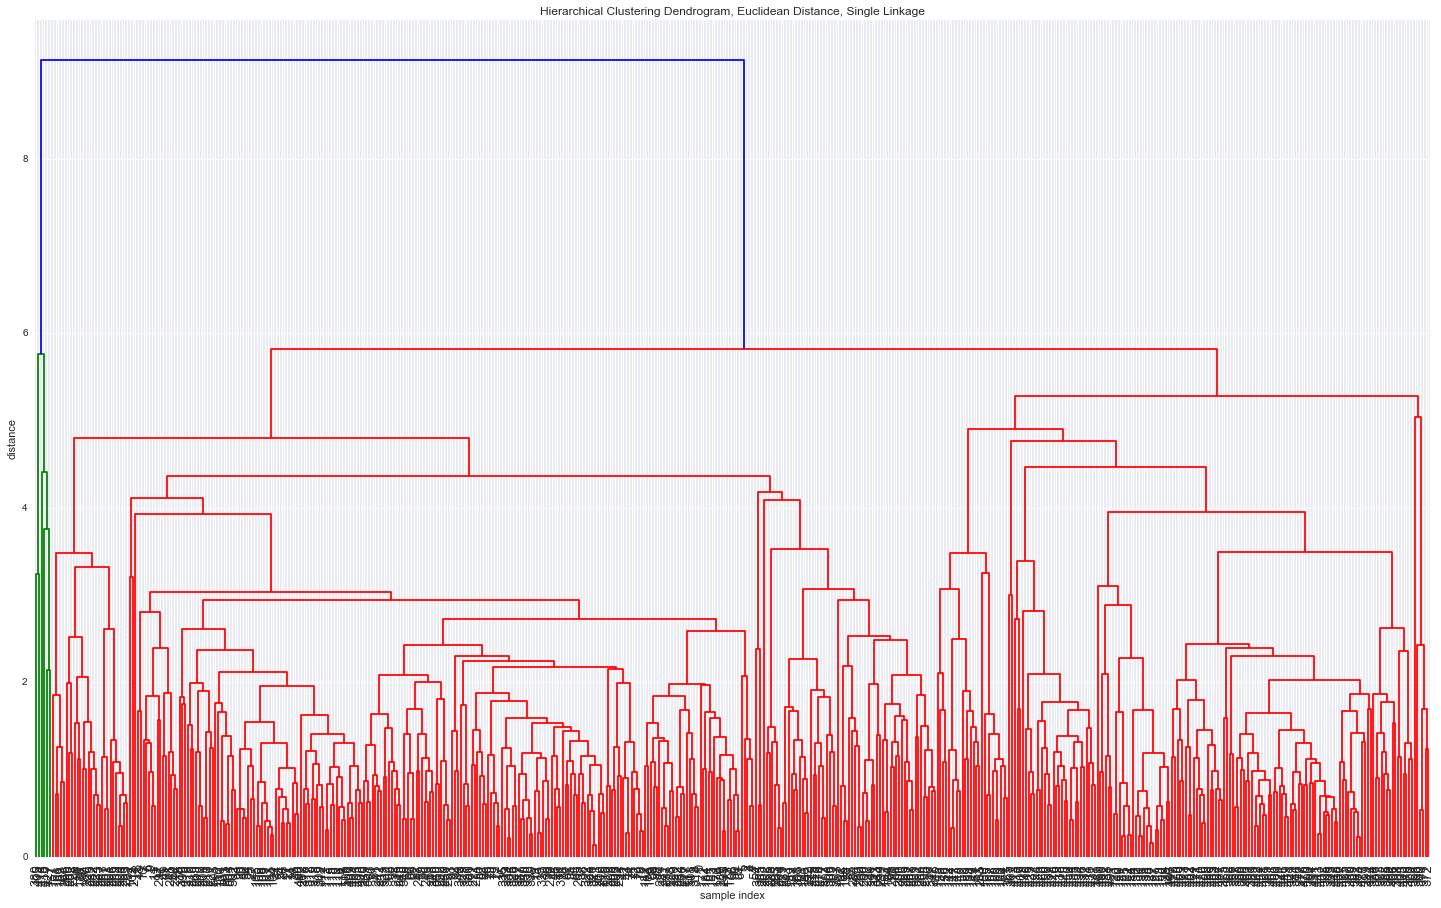

In [45]:
# calculate full dendrogram
plt.figure(figsize=(25, 15))
plt.title('Hierarchical Clustering Dendrogram, Euclidean Distance, Single Linkage')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z_single,
    leaf_rotation=90.,  # rotates the x axis labels 90 degrees
    leaf_font_size=13.,  # font size for the x axis labels
)
sns.despine()
plt.show()

If we don't want to see all of the merges, but just the last `n` clusters formed, pass in parameters for `truncate_mode` and `p`.

Let's make it so that we only visualize the last 3 cluster merges, and so that the number of points in each cluster is shown in parentheses per cluster:

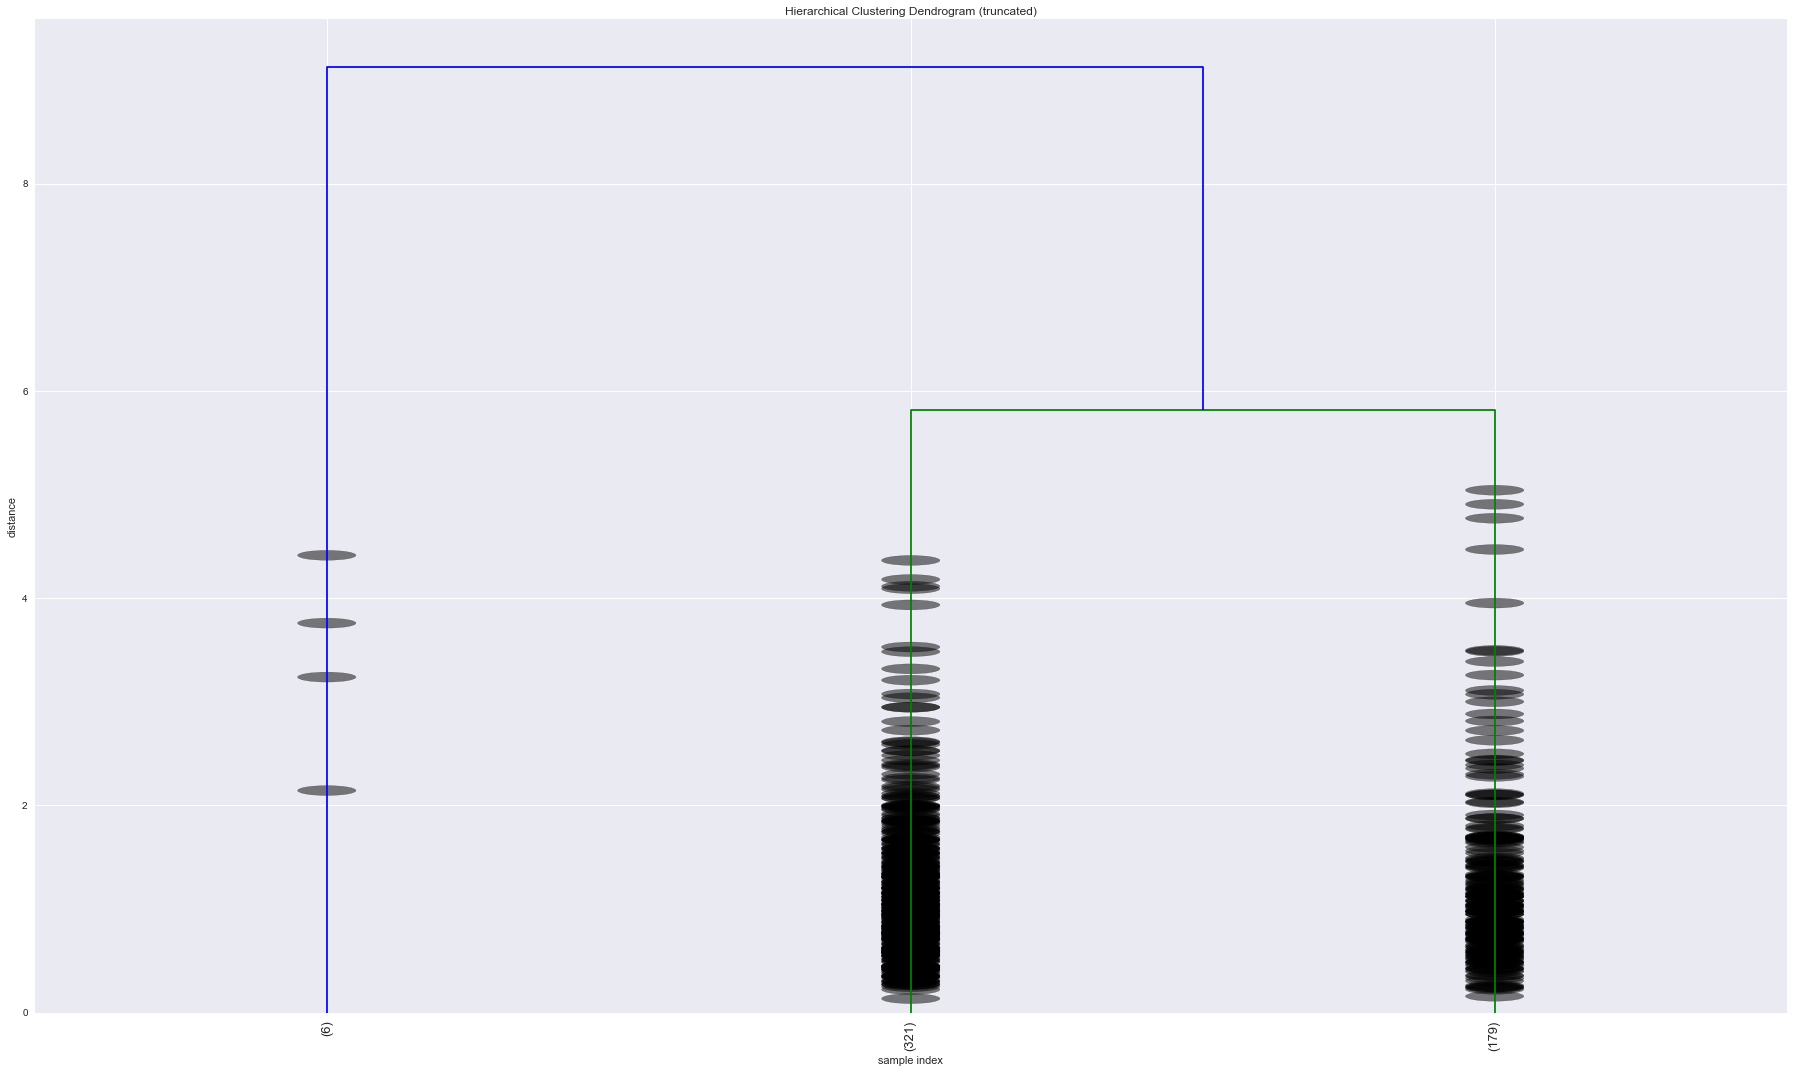

In [46]:
plt.figure(figsize=(25, 15))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z_single,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=3,  # show only the last 3 merged clusters
    leaf_rotation=90.,
    leaf_font_size=13.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
sns.despine()

plt.tight_layout()
plt.show()

#### Exercise Time

* Generate the complete (non-compressed) dendrograms for each of the other linkages, are the dendrograms substantially different for any of the linkage methods?

In [60]:
pass

### Generating flat clusters from a hierarchical clustering: Setting the number of clusters you want

At this point, what we really want to do is, given some number of clusters or some distance threshold beyond which we would want to cluster points, we want to see which cluster a given point is assigned to.

Compressing a given hierarchical clustering dendrogram into some number of flat, individual clusters can be done in a variety of ways. We will talk about two:
  1. Wanting a specific number of clusters to emerge (like K-means)
  2. Wanting a specific distance cutoff to generate individual clusters (like DBSCAN).

Both can be accomplished using the `fcluster` function found in `scipy.cluster.hierarchy`. Let's first generate the flat clusters based on wanting 3 final clusters.

The first argument to fcluster is the linkage matrix, the second argument is always the threshold we want to use (in our case the threshold maps to the number of clusters we want), and the third argument is a named parameter, `criterion`, to which we will pass the string `maxclust` to indicate that we want to threshold based on the number of clusters we want:

In [47]:
max_clust = 3
clusters_max_3clust = fcluster(Z_single, max_clust, criterion='maxclust')
clusters_max_3clust

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3,
       2, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2,

Now, let's add that labeling as a column to our original data, and visualize that clustering across all the feature scatter plots:

In [48]:
housing_data["max_3_clusters_euclidean"] = [ "cluster_"+ str(cl) for cl in clusters_max_3clust ]
housing_data.max_3_clusters_euclidean.value_counts()

cluster_2    321
cluster_3    179
cluster_1      6
Name: max_3_clusters_euclidean, dtype: int64

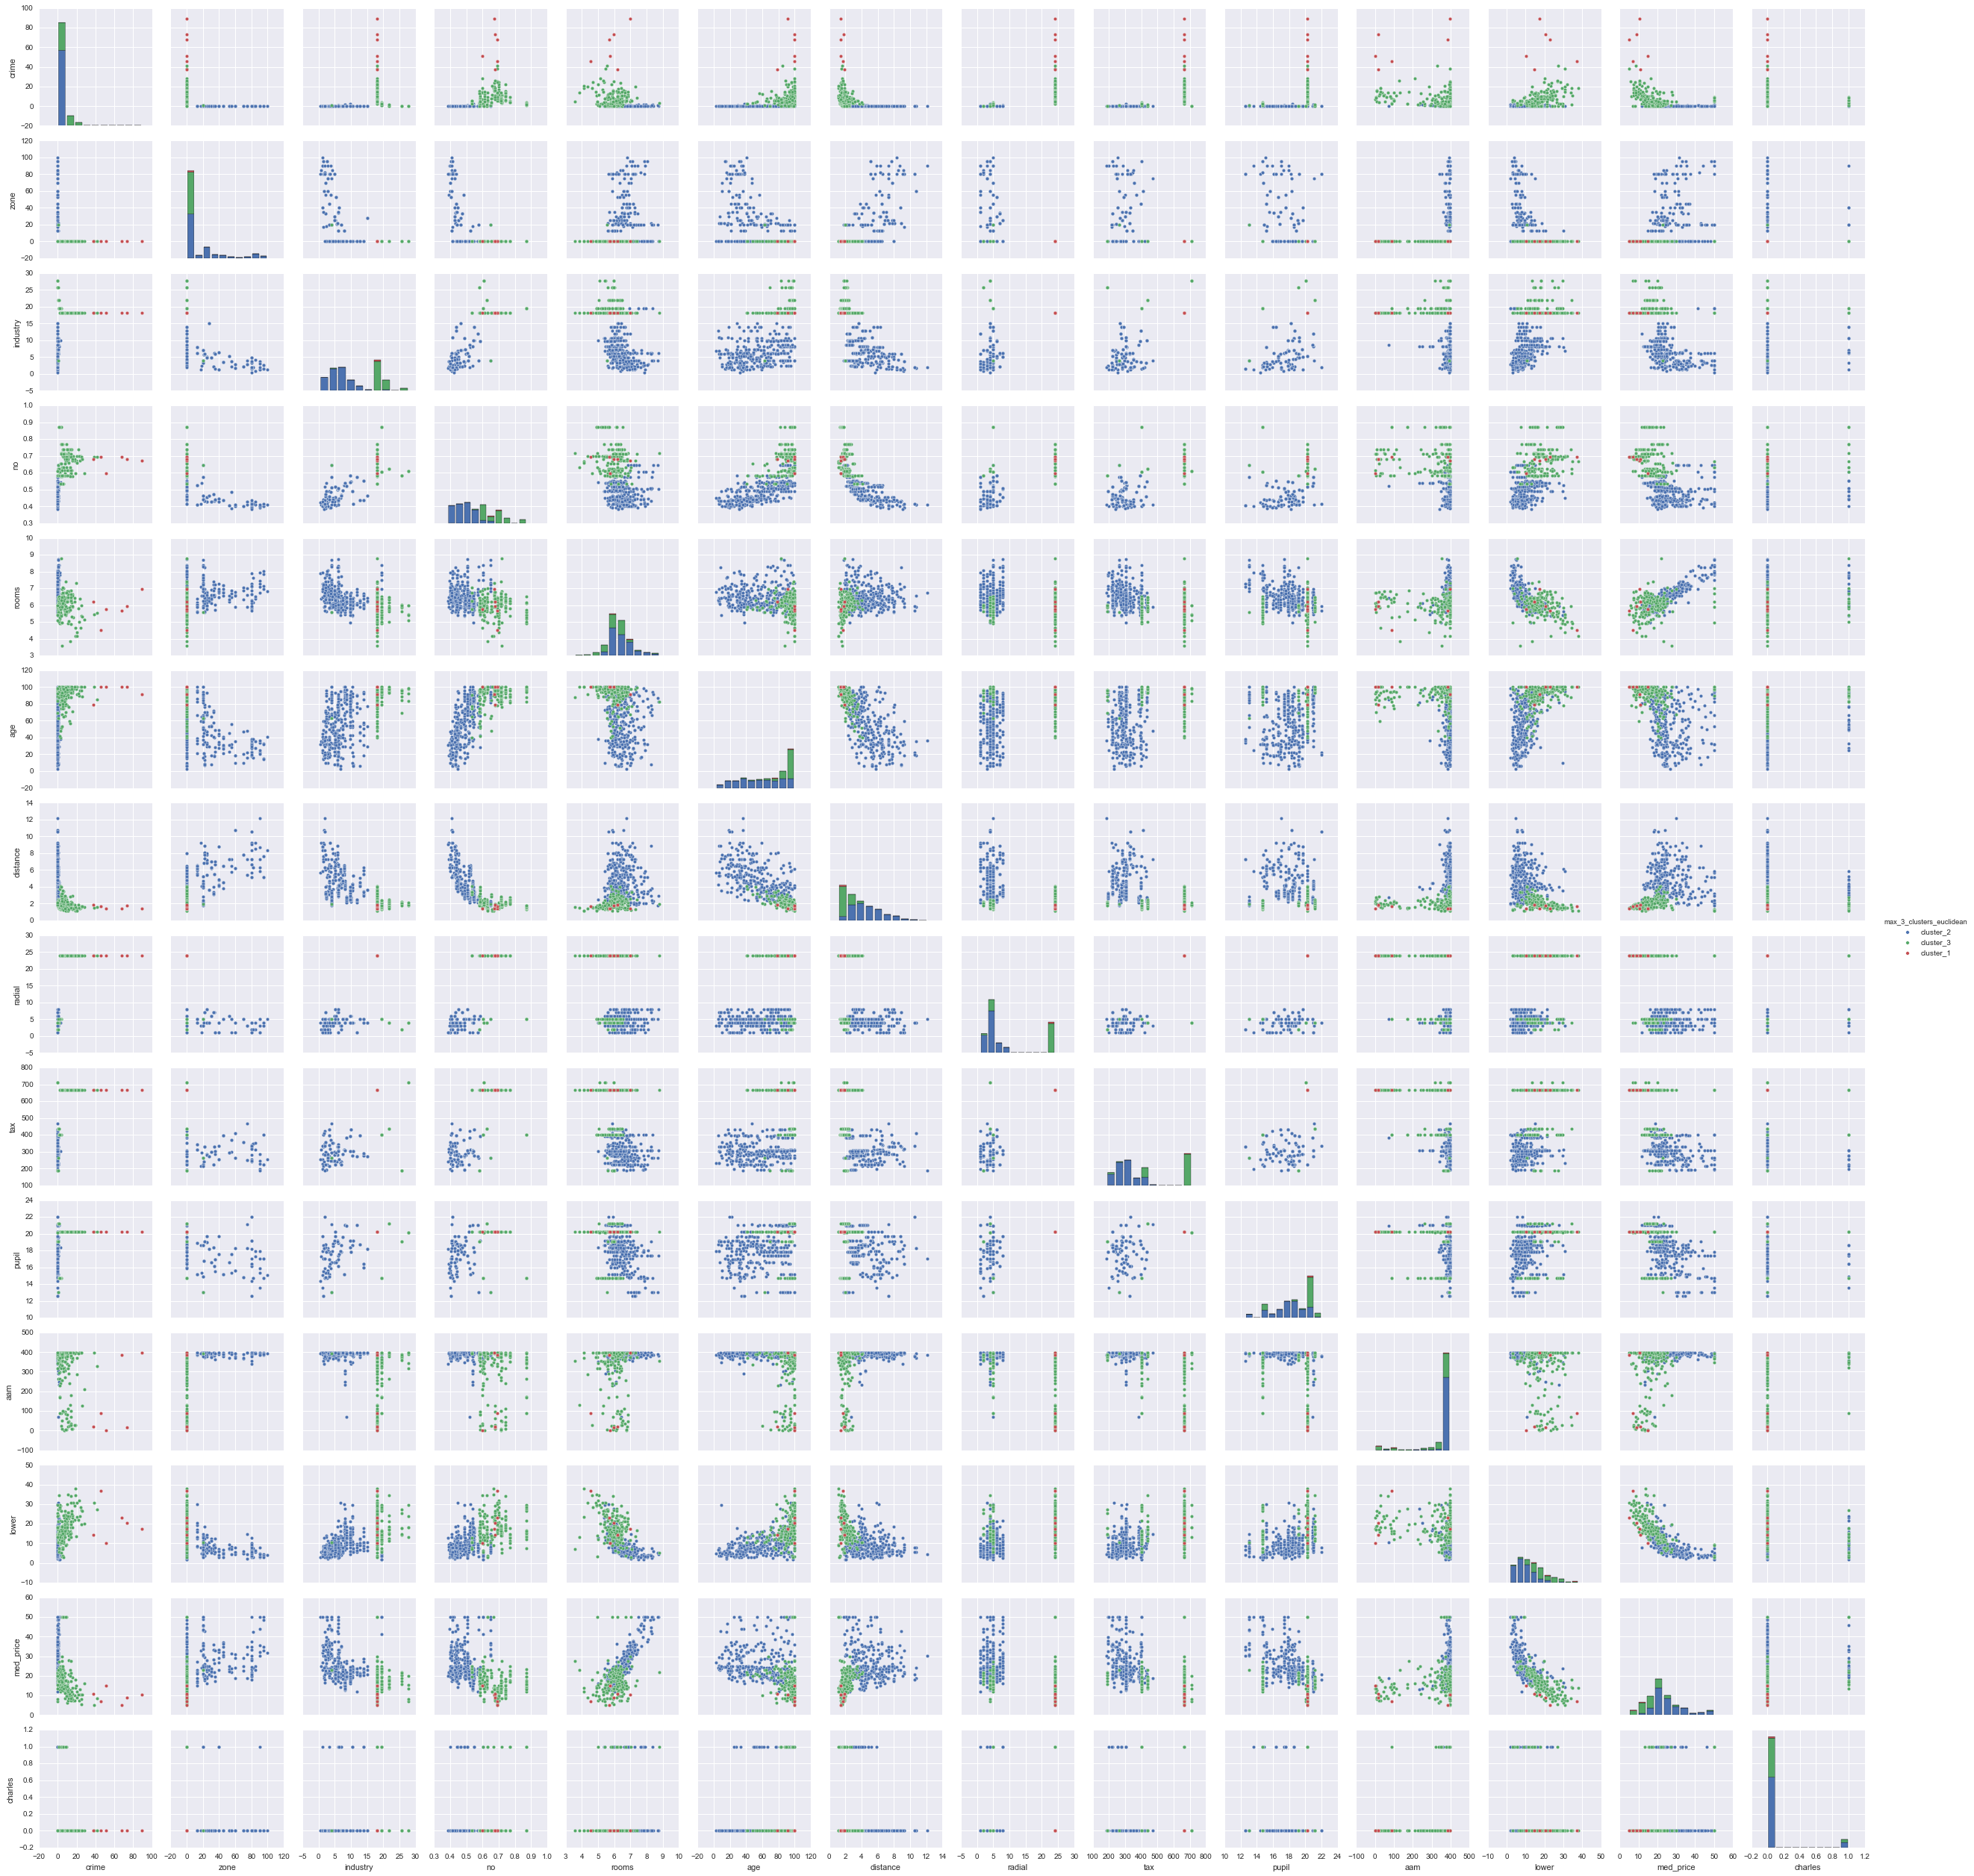

In [49]:
sns.pairplot(housing_data,hue="max_3_clusters_euclidean")

#### Exercise Time!!!

* Generate a flat clustering that creates 3 clusters for each of the other linkages. Do any of the linkage methods generate vastly different clusterings?

In [ ]:
pass

### Generating flat clusters from a hierarchical clustering: Setting a distance cutoff

In order to set a specific distance cutoff, we actually have to compute a **cophenetic matrix** from the original distance matrix, and set a cutoff value based on the cophenetic distances. 

What in the hell is a **cophenetic matrix**?

**A cophenetic matrix is a distance matrix where the original pairwise distances between samples are replaced by the computed distances between their clusters at the time of these clusters' merge.**

Let's compare the original distance distributions to the cophenentic distances as histograms and cumulative historgrams:

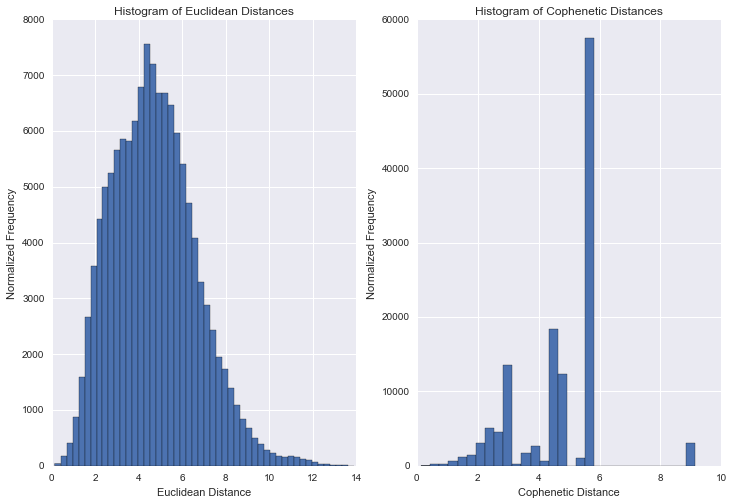

In [43]:
#create a big figure
figure = plt.figure(figsize=(12,8))
#add 4 subplots one at a time
figure.add_subplot(121)
sns.plt.hist(distances_euclidean, bins = 50)
sns.plt.xlabel("Euclidean Distance")
sns.plt.ylabel("Normalized Frequency")
sns.plt.title("Histogram of Euclidean Distances")

figure.add_subplot(122)
sns.plt.hist(coph_dists,bins=30)
sns.plt.xlabel("Cophenetic Distance")
sns.plt.ylabel("Normalized Frequency")
sns.plt.title("Histogram of Cophenetic Distances")

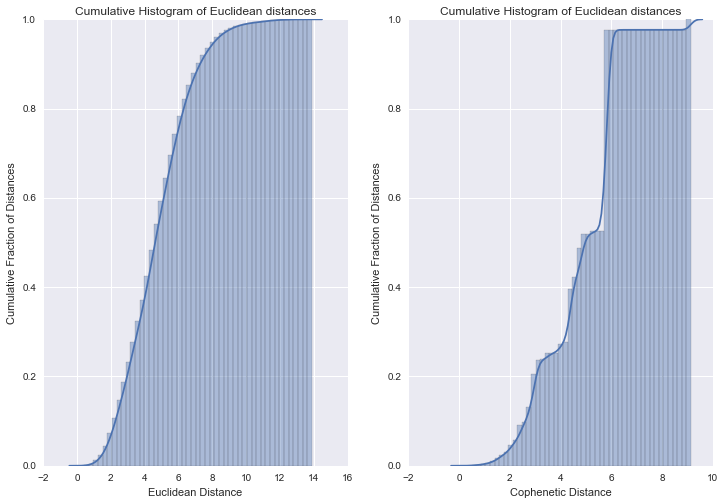

In [44]:
#create a big figure
figure = plt.figure(figsize=(12,8))
#add 4 subplots one at a time
figure.add_subplot(121)
sns.distplot(distances_euclidean,hist_kws={"cumulative":True},kde_kws={"cumulative":True})
sns.plt.xlabel("Euclidean Distance")
sns.plt.ylabel("Cumulative Fraction of Distances")
sns.plt.title("Cumulative Histogram of Euclidean distances")

figure.add_subplot(122)
sns.distplot(coph_dists,hist_kws={"cumulative":True},kde_kws={"cumulative":True})
sns.plt.xlabel("Cophenetic Distance")
sns.plt.ylabel("Cumulative Fraction of Distances")
sns.plt.title("Cumulative Histogram of Euclidean distances")

Notice that the cophenetic distance matrix radically segregates the data into separate "regions." It imposes what are called "discontinuities" on the distances, in order to segregate the points into clusters.

**Keep in mind that once you specify the linkage metric and distance metric, the cophenetic distances are automatically computed from the linkage matrix.**

Based on the cophenetic histograms, it looks like there might be 2 distributions of distances, those below ~5.5 and those above.

Let's set a threshold around 5.5 to split the hierarchical clustering on, and see what cluster labelings we get.

In [45]:
max_d = 5.5
clusters_d = fcluster(Z_single, max_d, criterion='distance')
clusters_d

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4,
       3, 3, 3, 4, 4, 3, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3,

In [51]:
housing_data["clusters_maxd"] = [ "cluster_"+ str(cl) for cl in clusters_d ]
housing_data.clusters_maxd.value_counts()

cluster_3    321
cluster_4    179
cluster_2      4
cluster_1      2
Name: clusters_maxd, dtype: int64

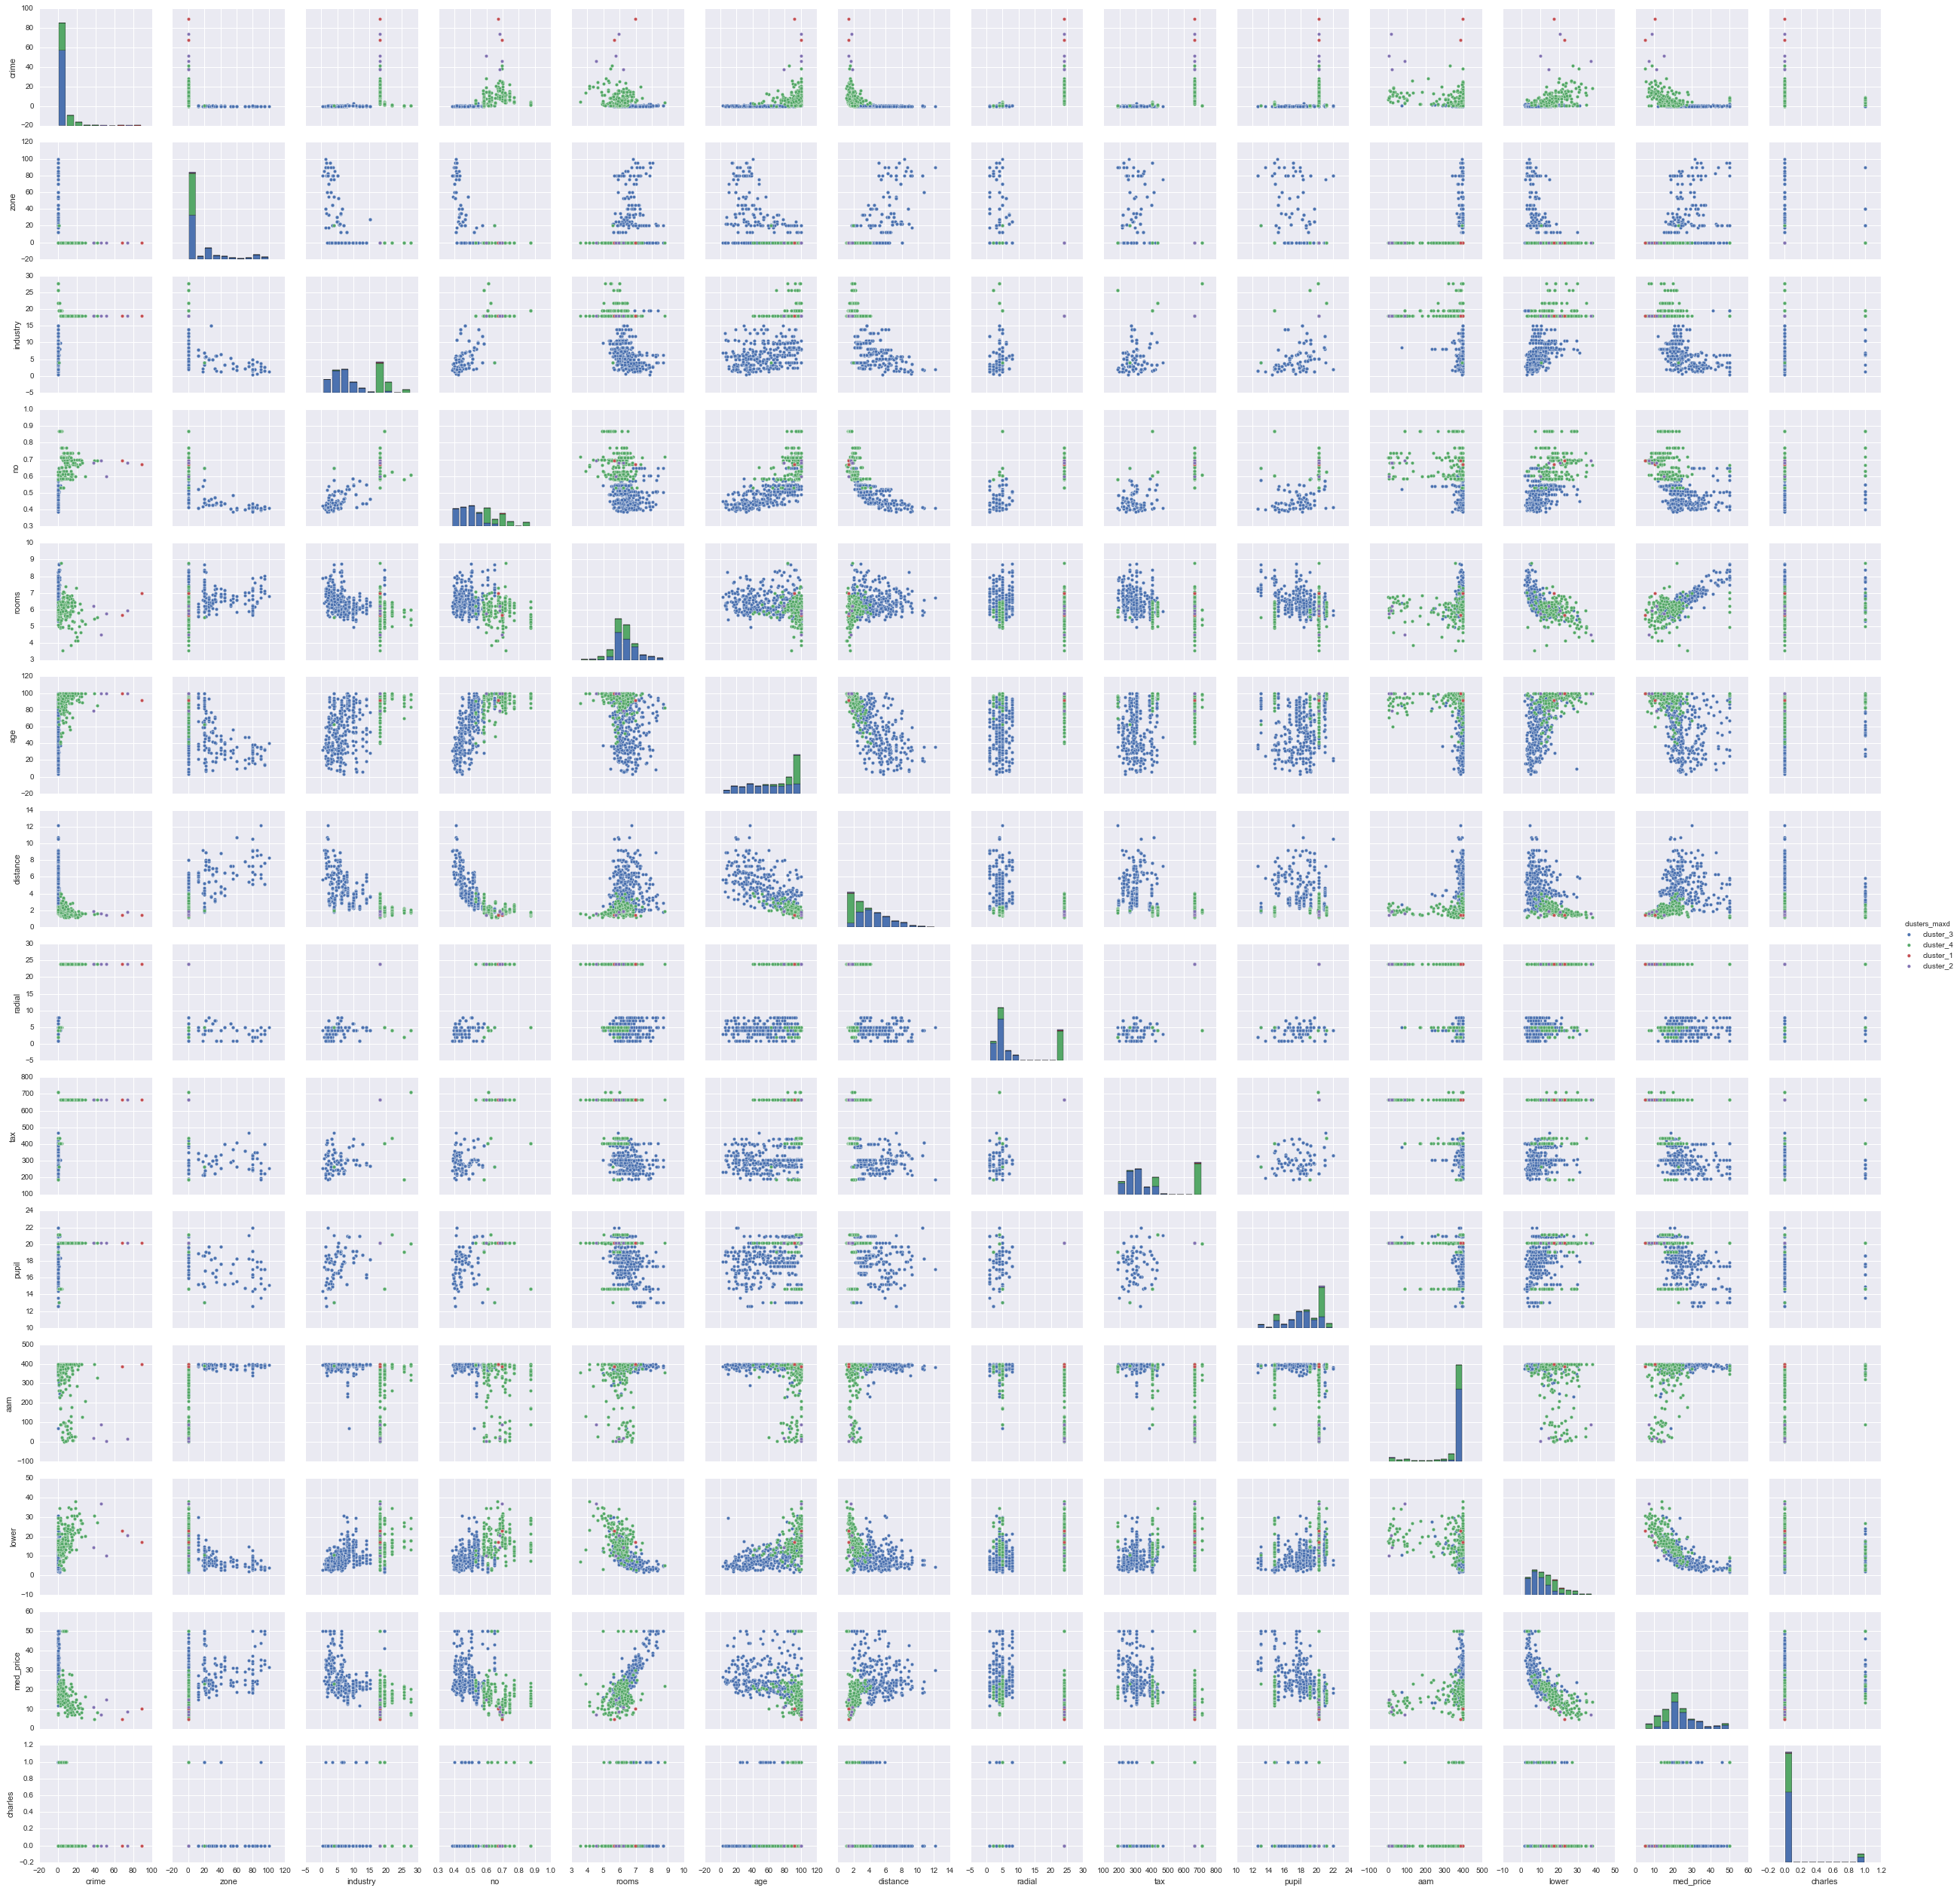

In [50]:
sns.pairplot(housing_data,hue="clusters_maxd")

#### Exercise Time!!!

* Use a couple different cophenetic distance cuotff values to generate flat clusters. What happens when you set a smaller value (around 2)? What happens when you set a larger value (anything greater than 6 in our case)?

### Common Distance Metrics: Cosine and Correlation Distance

For the rest of the lesson, we are going to explore different distance metrics, and see if any one of them can give us a "good" clustering, based on our intuitions and some of the metrics we've learned about in evaluating clustering (cophenetic coefficient, silhouette score).

**Cosine Distance:** Given two points (samples/rows), this is the cosine of the angle between the two points, when the two points are treated as vectors that are pointing from the 0 point in the sample space.

Really, what this measures is whether two points in any "space" (where the space is defined by the columns in your dataset) are a) pointing in the same direction, and whether they fall on the same "line" passing through them and the 0-point of the space (the hypothetical "row" that has all 0's in it for the given dataset). This distance measurement does not account for differences in the magnitude between the two points (like Euclidean distance does), and also does not account for scalar (numeric) shifts.

$$d_{cosine}(x,y) = 1-cos(x,y)$$

**So, two points that are very far apart from each other, but that lie on the same line from (0,0) actually have a cosine distance of 0 from each other (cosine of 0 is 1, 1-1=0). However, two points that are pointing in the same direction, but shifted relative to each other will have a non-zero cosine distance.**

A slightly different distance metric ignores these "shifts" in the space of your columns, so that as long as they are pointing in the same direction, they are identical, regardless of where they "live" in space. This is called....

**Correlation Distance:** Given two points (samples/rows) in a dataset, this is simply the correlation between the two points, and is invariant (like correlation) to  multiplication by or addition of scalar values (which means if one row is simply an $mx +b$ transformation of the other, their correlation will be 1).

So, cosine and correlation distance compute very similar distances between points, but correlation distance is effectively a "normalized" cosine distance. 

**A correlation distance is the same as a cosine distance that is invariant to shifts. So, the cosine and correlation distances would give identical results if each row (sample) is L2 normalized (more on that later).**

Let's look at what using each of these distance metrics and single linkage does for hierarchical clustering :

In [57]:
Z_cos = linkage(housing_data_scaled, metric='cosine', method='single')
k=3
clusters_cos=fcluster(Z_cos, k, criterion='maxclust')
housing_data["max_3_clusters_cosine"] = ["cluster_"+str(label) for label in clusters_cos]
housing_data.max_3_clusters_cosine.value_counts()

cluster_1    504
cluster_3      1
cluster_2      1
Name: max_3_clusters_cosine, dtype: int64

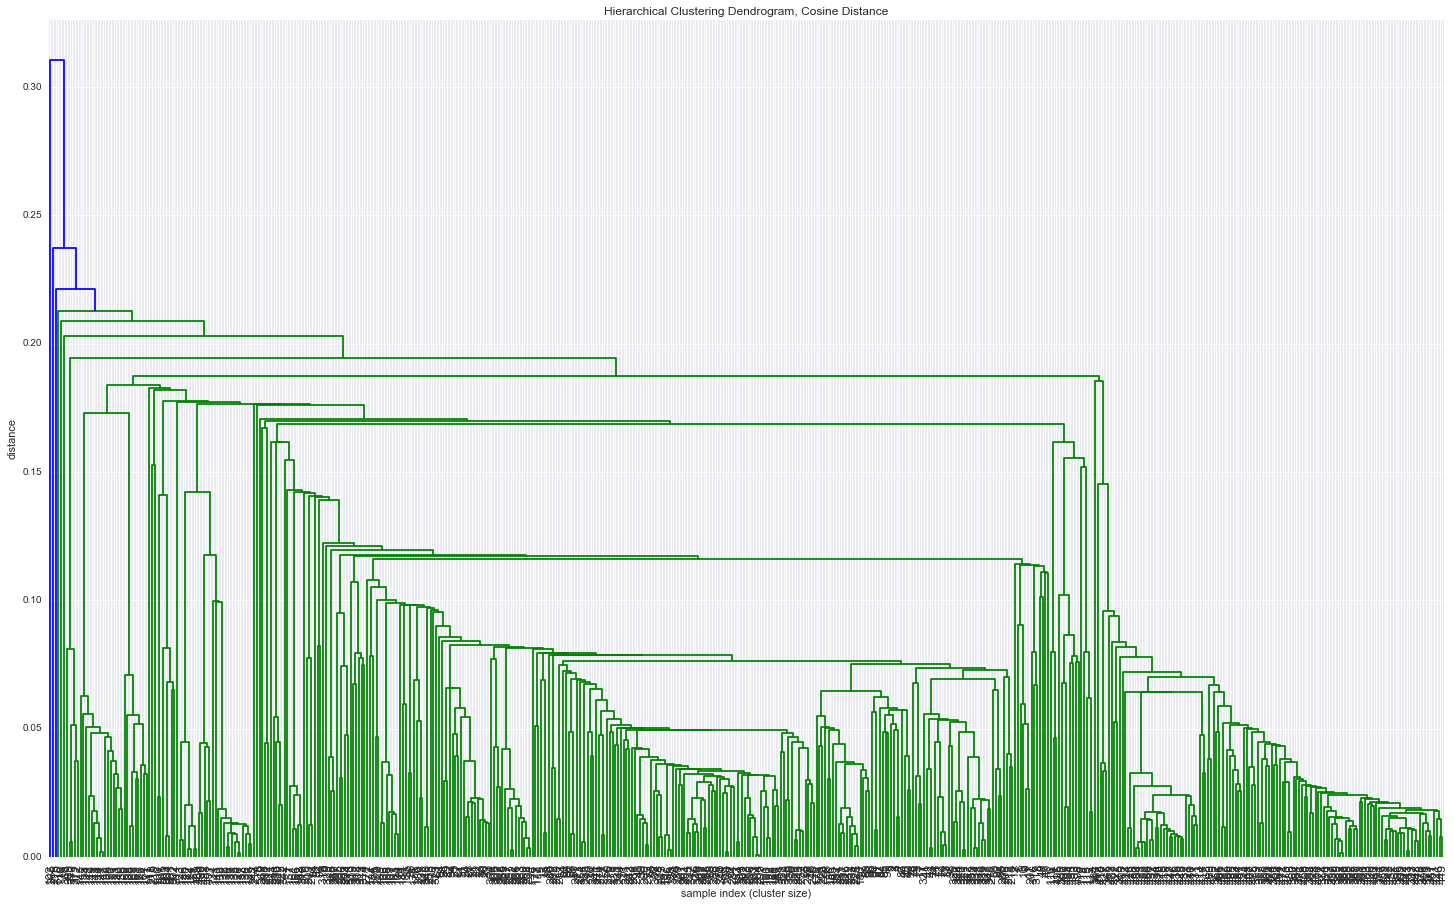

In [58]:
plt.figure(figsize=(25, 15))
plt.title('Hierarchical Clustering Dendrogram, Cosine Distance')
plt.xlabel('sample index (cluster size)')
plt.ylabel('distance')

dendrogram(
    Z_cos,
    leaf_rotation=90.,
    leaf_font_size=12.,

)
plt.show()

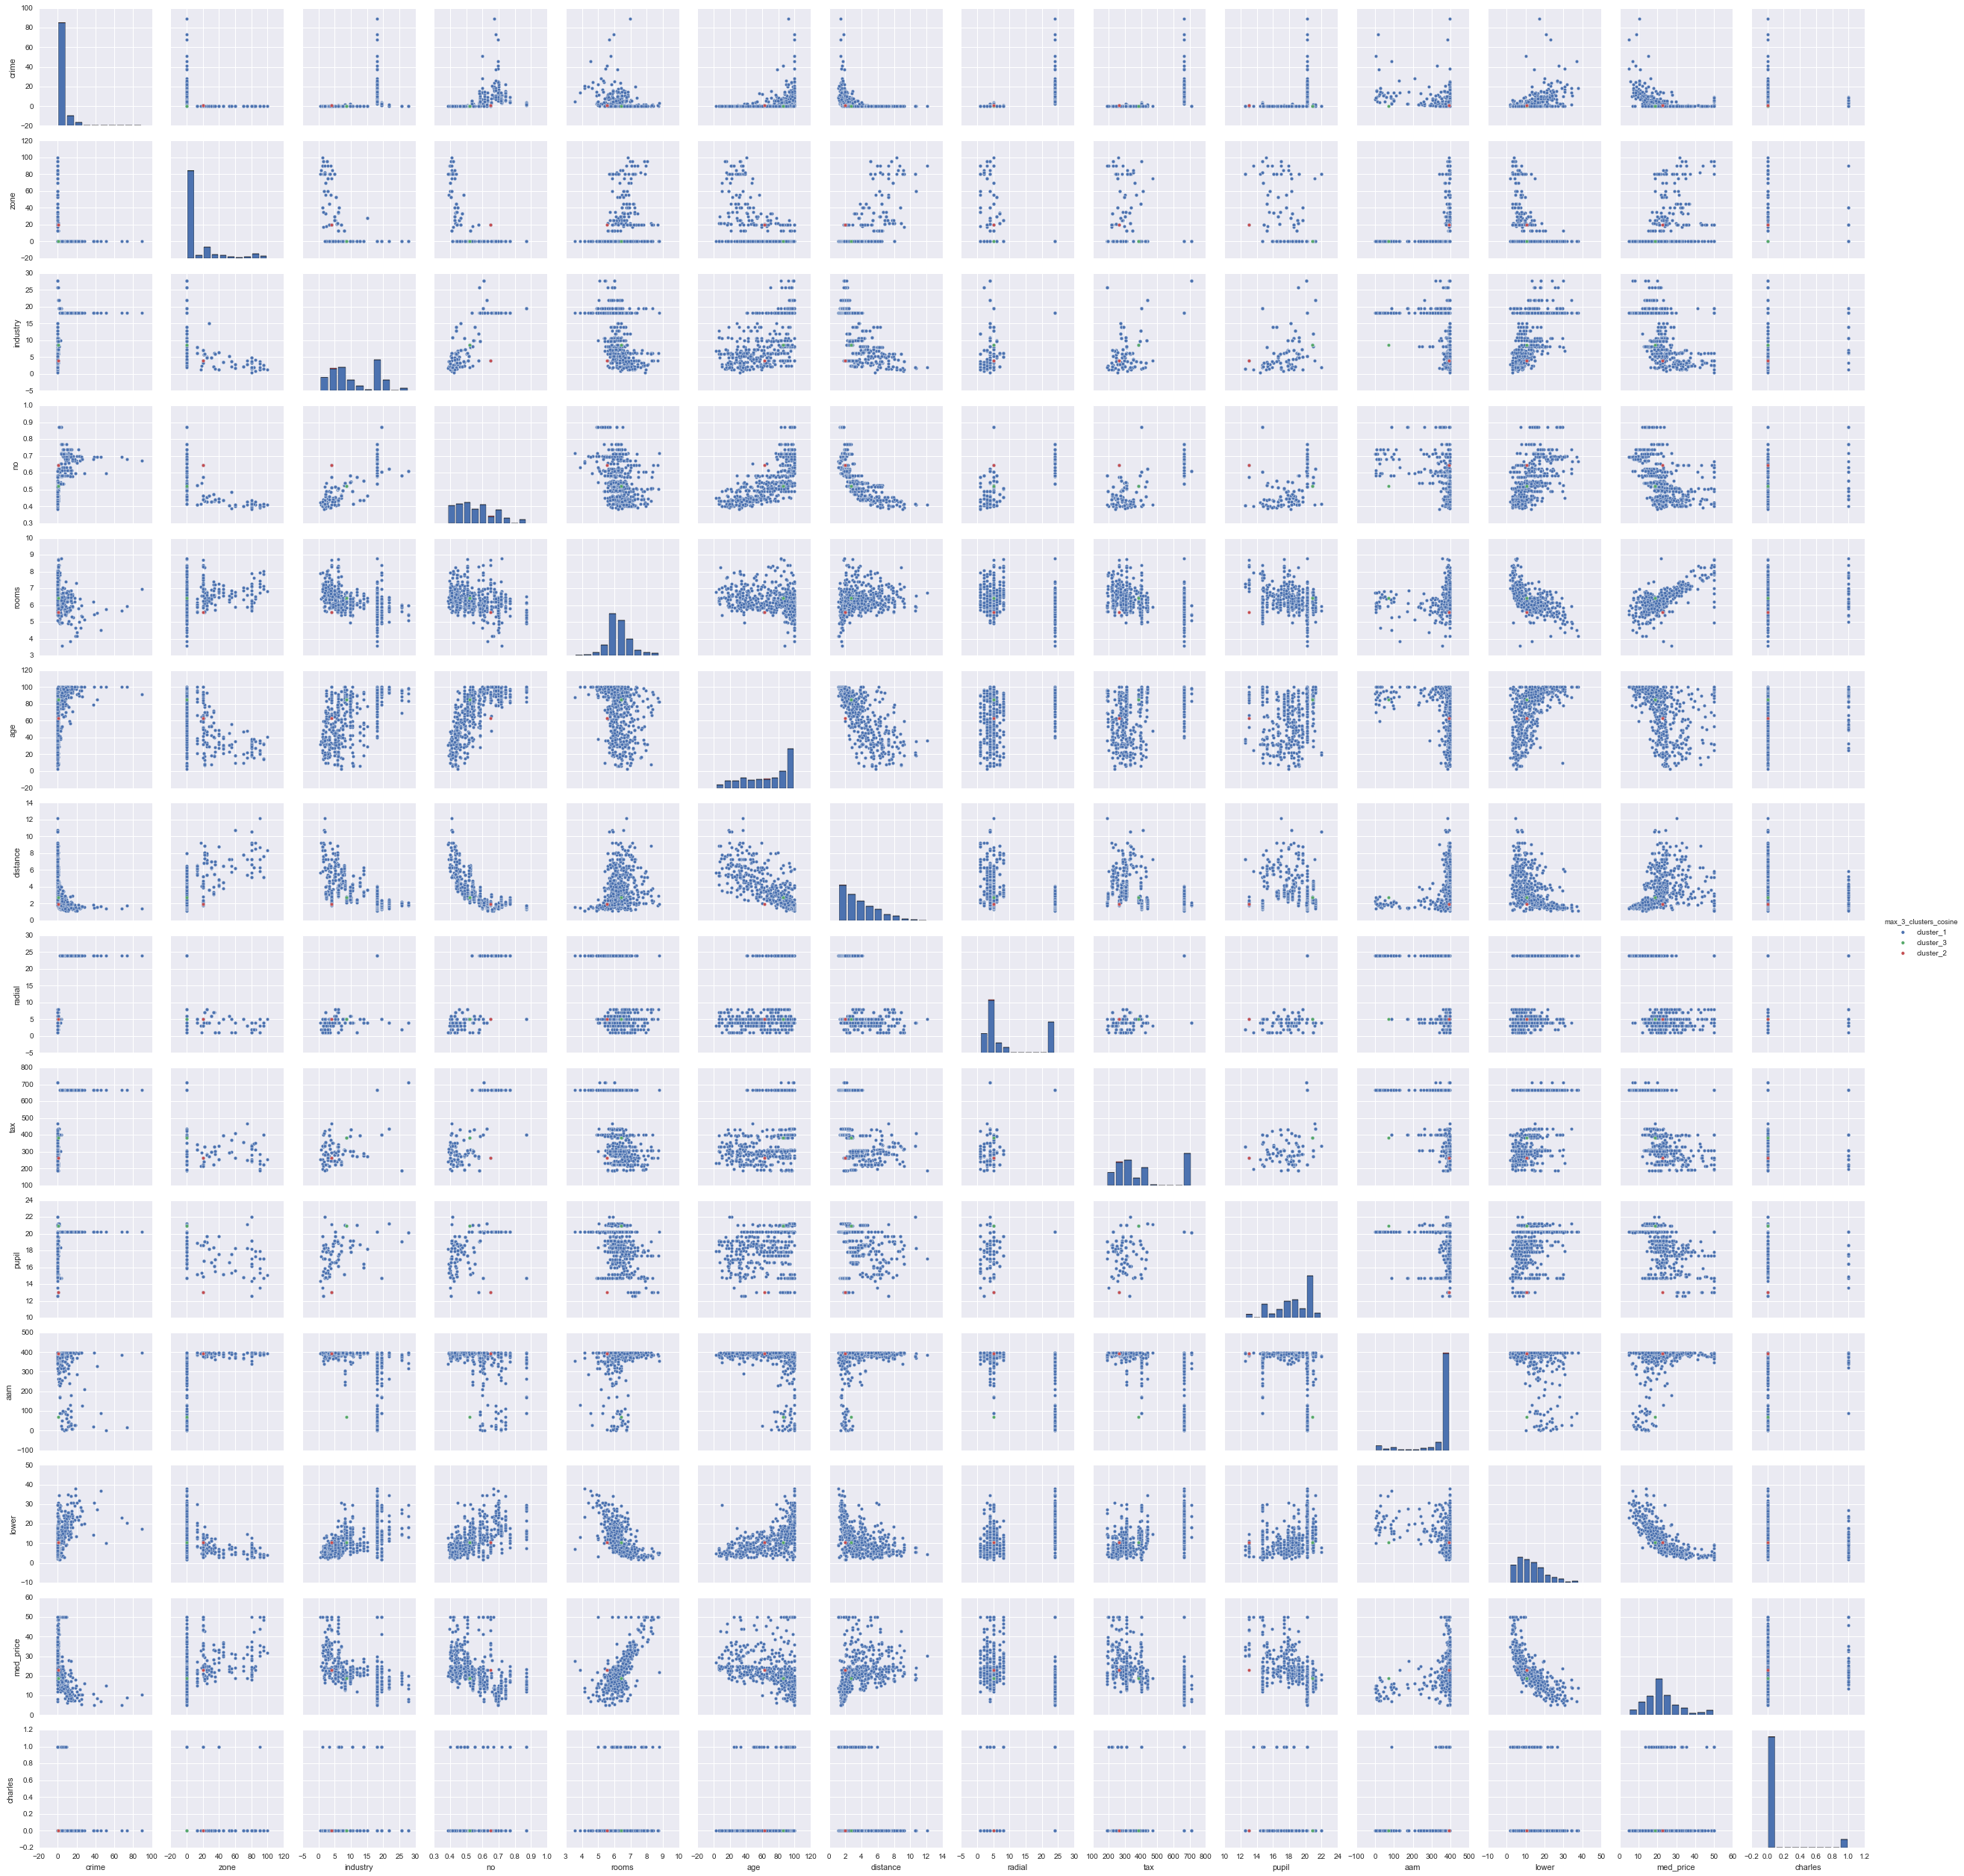

In [30]:
sns.pairplot(housing_data,hue="max_3_clusters_cosine")

In [31]:
Z_corr = linkage(housing_data_scaled, metric='correlation', method='single')
k=3
clusters_corr=fcluster(Z_corr, k, criterion='maxclust')
housing_data["max_3_clusters_corr"] = ["cluster_"+str(label) for label in clusters_corr]
housing_data.max_3_clusters_corr.value_counts()

cluster_1    504
cluster_3      1
cluster_2      1
Name: max_3_clusters_corr, dtype: int64

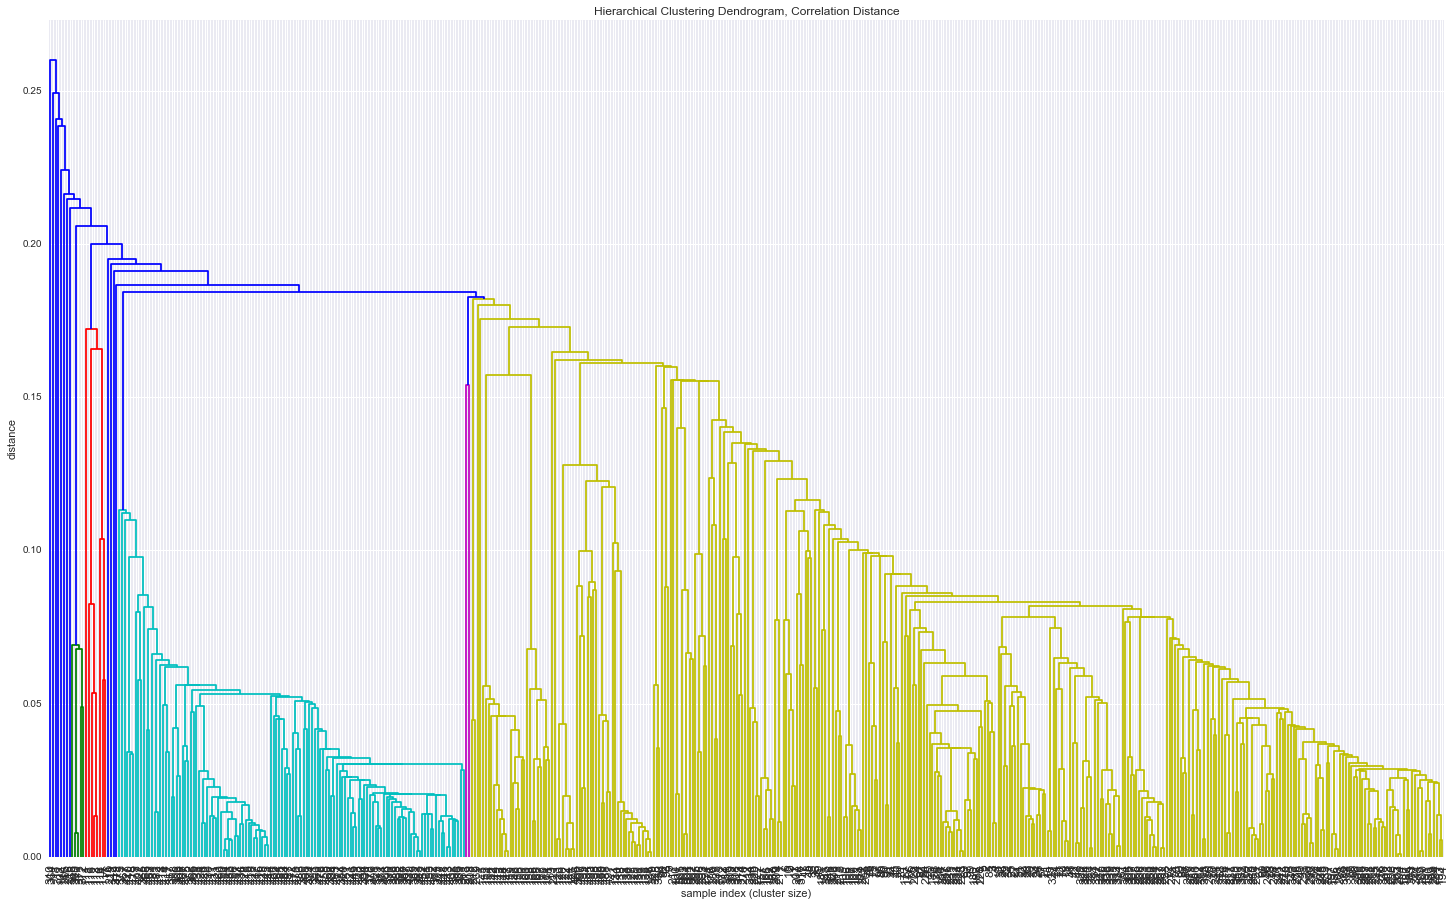

In [33]:
plt.figure(figsize=(25, 15))
plt.title('Hierarchical Clustering Dendrogram, Correlation Distance')
plt.xlabel('sample index (cluster size)')
plt.ylabel('distance')

dendrogram(
    Z_corr,
    leaf_rotation=90.,
    leaf_font_size=12.,

)
plt.show()

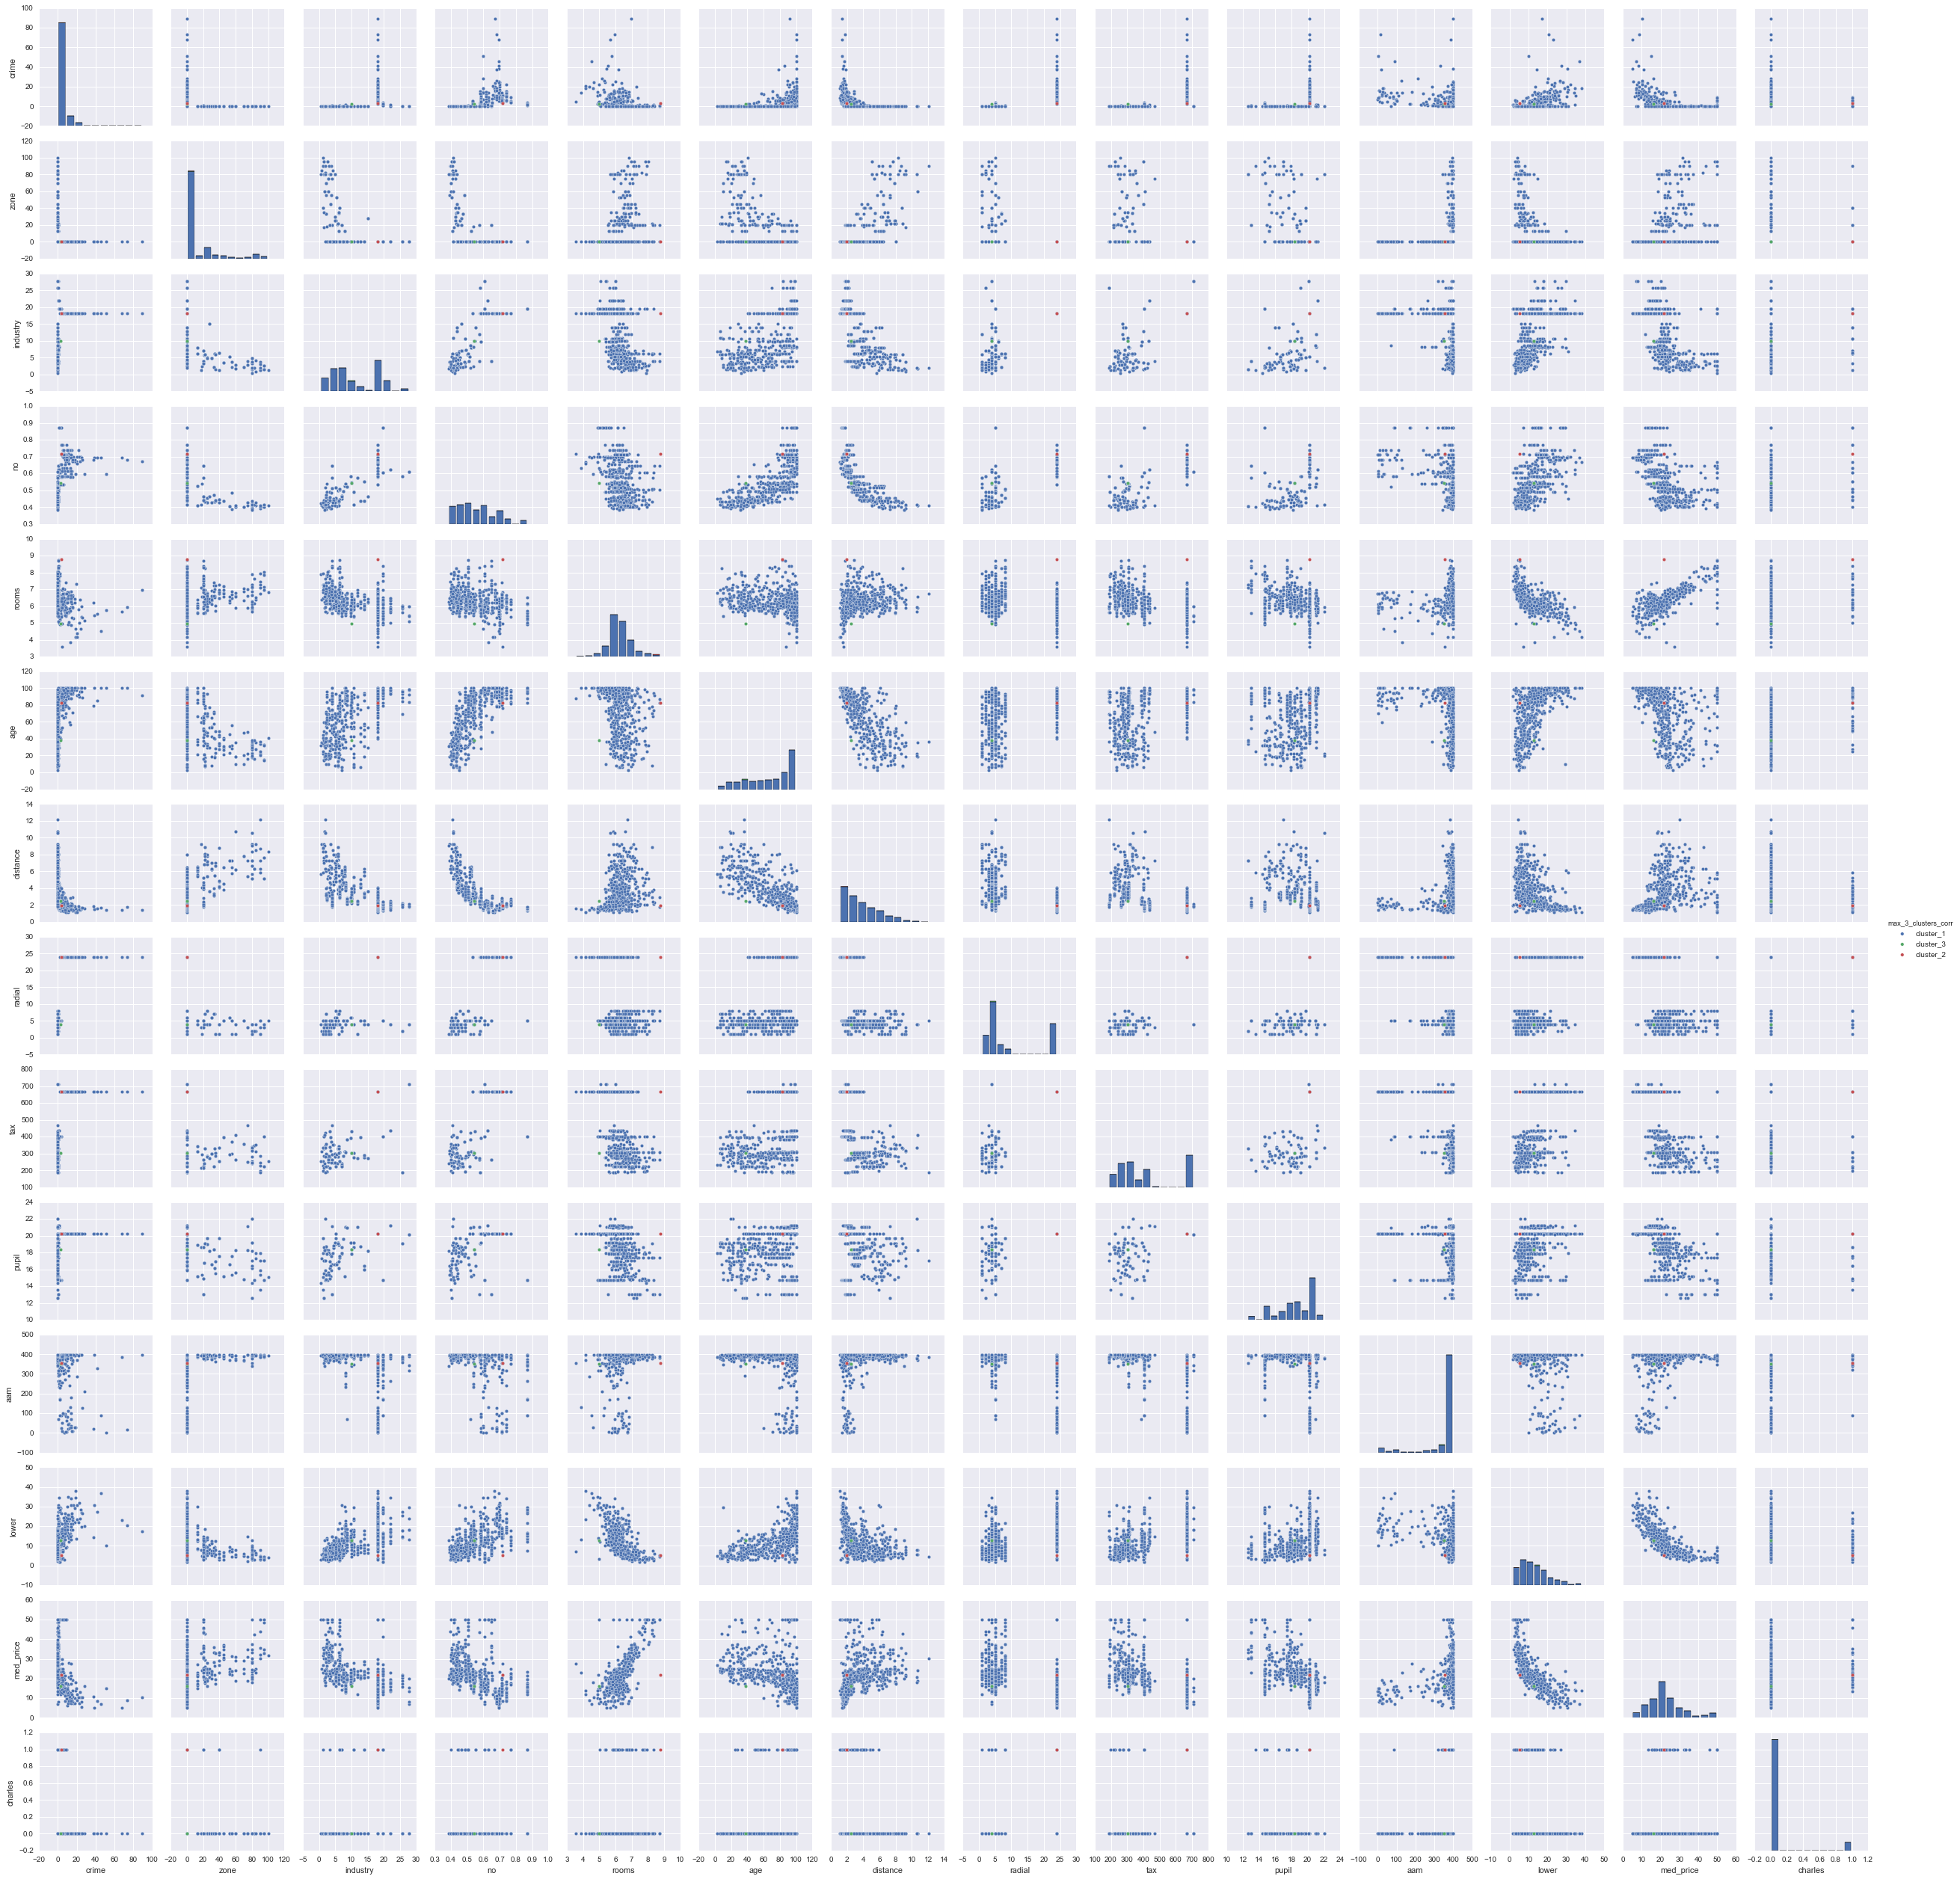

In [34]:
sns.pairplot(housing_data,hue="max_3_clusters_corr")

### Common Distance Metrics: Manhattan Distance

**Manhattan/cityblock/Minkowski Distance**: This metric goes by many names, but for any two samples, it is just the sum of the absolute differences across every feature (column) defined for those samples.

$$d_{manhattan}(x,y) = \sum_{i=1}^{n}|x_i-y_i|$$

![manhattan distance](../images/manhattan_distance.png)

**Note:** The manhattan distance can be a useful distance metric when measuring similarity between two binary vectors, or  between two categorical variable vectors of equal length (here it becomes the sum of the number of columns with matching categorical values across the two vectors) and is actually called the [Hamming Distance](https://en.wikipedia.org/wiki/Hamming_distance).

In [37]:
Z_manhattan = linkage(housing_data_scaled, metric='cityblock', method='single')
k=3
clusters_manh=fcluster(Z_manhattan, k, criterion='maxclust')
housing_data["max_3_clusters_manh"] = ["cluster_"+str(label) for label in clusters_manh]
housing_data.max_3_clusters_manh.value_counts()

cluster_1    504
cluster_3      1
cluster_2      1
Name: max_3_clusters_manh, dtype: int64

### Common Distance Metrics: Chebyshev Distance

**Chebyshev Distance:** Given two points (samples/rows) in a dataset, this is the maximum distance between the two points in any single dimension.

$$d_{chebyshev}(x,y) = max_{i}(|x_i-y_i|)$$

**Note:** This distance measurement is very sensitive to outlying measurements along any single dimension (column), but would be a useful distance metric when the difference between points is reflected more by differences in individual dimensions rather than the distance across all dimensions considered together. It is commonly used in chess strategies (think of the distance of any chessboard square from a given square):

![chebyshev distance](../images/chebyshev_distance.png)

In [62]:
Z_cheb = linkage(housing_data_scaled, metric='chebyshev', method='single')
k=3
clusters_cheb=fcluster(Z_cheb, k, criterion='maxclust')
housing_data["max_3_clusters_cheb"] = ["cluster_"+str(label) for label in clusters_cheb]
housing_data.max_3_clusters_cheb.value_counts()

cluster_2    503
cluster_1      2
cluster_3      1
Name: max_3_clusters_cheb, dtype: int64

### Common Distance Metrics: Jaccard Distance

**Jaccard Distance:** This distance metric is actually best understood as a way of comparing two sets of entities. Briefly, it is the number of members those sets share divided by the total number of distinct elements across both sets. Two sets with all members in common (that are identical) have a jaccard distance of 0, whereas two sets with no members in common have a jaccard distance of 1.

$$d_{jaccard}(A,B) = 1 - \frac {A \cap B}{A \cup B}$$

The general jaccard distance for any two vectors is:

$$d_{jaccard}(x,y) = 1 - \frac {\sum_{i=1}^{n}min(x_i,y_i)}{\sum_{i=1}^{n}max(x_i,y_i)}$$

This means that the distance between two vectors is the sum of the minimum values across every dimension (column) divided by the sum of the maximum values across each column.

**Note:** This is a very common distance metric that is used when working with natural language problems (where our rows are documents, and the columns are the words in those documents).

### Hierarchical Clustering Tips:

* If data is really sparse, L-2 normalize along rows (make mean of rows 0 and "length" of each row the same)
* Single linkage, regardless of distance metric, strongly segregates outliers
* Average/Complete linkage both tend to produce more "symmetric" or evenly sized clusters
* Many distance metrics will yield fairly similar results, big differences in clustering happen usually as a result of the linkage method you use (how you merge successive clusters together).
* In general, think about your data, and make sure you have a legitimate justification for why you're using a specific metric.
* Hierarchical clustering is generally infeasible when you have "big data", so only use it when the number of samples is not super huge (1000s of samples might work, 10K samples and higher can take a very long time to compute).

There are lost of other [distance metrics](http://docs.scipy.org/doc/scipy/reference/spatial.distance.html) that have been implemented in scipy. Check them out if youre interested.